<a href="https://colab.research.google.com/github/deep0505sharma/Domain-Adaptation-For-Equipment-Fault-Detection/blob/main/DA_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from __future__ import print_function
import os
import math
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.models as models
from torchvision import datasets, transforms

### Full code

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras import backend as K

#### Dataset preperation

In [8]:
import os
import pickle

In [11]:
os.chdir('/content/drive/MyDrive/Research_IITRoorkee/Deepak')

In [12]:
with open("mfcc_caseA", "rb") as fp:
    source = pickle.load(fp)

In [13]:
with open("mfcc_caseB", "rb") as fp:
    target = pickle.load(fp)


In [14]:
with open("y_CaseA", "rb") as fp:
    y_source = pickle.load(fp)

In [15]:
with open("y_CaseB", "rb") as fp:
    y_target = pickle.load(fp)

In [16]:
len(source[0])

20

In [17]:
def normalise(data):
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

# Assuming the data is stored in a list called 'data'
    normalized_data = []

# Flatten the data to two dimensions
    flattened_data = [np.ravel(row) for row in data]

# Create an instance of MinMaxScaler
    scaler = MinMaxScaler()

# Convert the flattened data to a numpy array
    data_array = np.array(flattened_data,dtype=object)

# Normalize the data
    normalized_array = scaler.fit_transform(data_array)

# Reshape the normalized array back to the original shape
    normalized_data = [row.reshape(13, 126).tolist() for row in normalized_array]

# Return the normalized data
    normalized_data = np.array(normalized_data)
    return normalized_data



In [18]:
def trunk(source):
  import numpy as np
  max_length = 126  # Maximum desired length

  # Iterate over each array in the list
  for i in range(len(source)):
      array = source[i]
      current_length = array.shape[1]  # Get the current length of the array

      if current_length < max_length:
          # Pad the array with zeros to reach the maximum length
          pad_width = ((0, 0), (0, max_length - current_length))
          padded_array = np.pad(array, pad_width, mode='constant')
          source[i] = padded_array
      elif current_length > max_length:
          # Truncate the array to the maximum length
          truncated_array = array[:, :max_length]
          source[i] = truncated_array
  return source

In [ ]:
# mand =normalise(source_m)
# source = normalise(source_o)
# target =normalise(target_o)
# pader = normalise(target_o)

In [19]:
source = trunk(source)
target = trunk(target)

In [20]:
print(len(source))
print(len(target))
print(len(y_source))
print(len(y_target))

956
957
956
957


In [ ]:
# # Allign the data
# def align(X1,Y1,X2,Y2):
#   # Find the unique classes in Y1
#   classes = set(Y1)

#   # Initialize empty lists for filtered data
#   filtered_X1 = []
#   filtered_Y1 = []
#   filtered_X2 = []
#   filtered_Y2 = []

#   # Iterate over each class
#   for class_val in classes:
#       # Find the indices of rows with the current class value in Y1
#       class_indices = [i for i, y in enumerate(Y1) if y == class_val]

#       # Filter X1 and Y1 to include only the rows with the current class value
#       filtered_X1.extend([X1[i] for i in class_indices])
#       filtered_Y1.extend([Y1[i] for i in class_indices])

#       # Find the rows in X2 that correspond to the rows with the current class value in Y1
#       filtered_X2.extend([X2[i] for i in class_indices])
#       filtered_Y2.extend([Y2[i] for i in class_indices])

#   return filtered_X1,filtered_Y1,filtered_X2,filtered_Y2

In [ ]:
# source,y_mandeley,target,y_paderborn = align(source,y_mandeley,target,y_paderborn);

In [ ]:
# print(len(source))
# print(len(target))
# print(len(y_mandeley))
# print(len(y_paderborn))

In [ ]:
# def shuffle(data,label,data2,label2):
#   import random

#   # Combine x_values and y_values into a single list of tuples
#   combined = list(zip(data, label,data2,label2))

#   # Shuffle the combined list
#   random.shuffle(combined)

#   # Unzip the shuffled list back into separate x_values and y_values lists
#   x_values_shuffled, y_values_shuffled,x_values_shuffled2, y_values_shuffled2 = zip(*combined)

#   return x_values_shuffled, y_values_shuffled,x_values_shuffled2, y_values_shuffled2


In [ ]:
# source,y_mandeley,target,y_paderborn = shuffle(source,y_mandeley,target,y_paderborn);

In [21]:
def shuffle(data,label):
  import random

  # Combine x_values and y_values into a single list of tuples
  combined = list(zip(data, label))

  # Shuffle the combined list
  random.shuffle(combined)

  # Unzip the shuffled list back into separate x_values and y_values lists
  x_values_shuffled, y_values_shuffled = zip(*combined)

  return x_values_shuffled, y_values_shuffled

In [22]:
source,y_source = shuffle(source,y_source);
target, y_target = shuffle(target, y_target);

In [23]:
source = source[:750]
y_source = y_source[:750]
target_train = target[:750]
target_test = target[750:950]

In [24]:
y_train = y_target[:750]
y_test =y_target[750:950]

In [25]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [26]:
s_n =0;s_i=0;s_o=0;
t_n =0;t_i=0;t_o=0;
for i in range(100):
  if(y_source[i]==0):
      t_n=i;

  if(y_source[i]==1):
      t_i=i

  if(y_source[i]==2):
      t_o=i

  if(y_target[i]==0):
      s_n=i

  if(y_target[i]==1):
      s_i=i

  if(y_target[i]==2):
      s_o=i


In [27]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

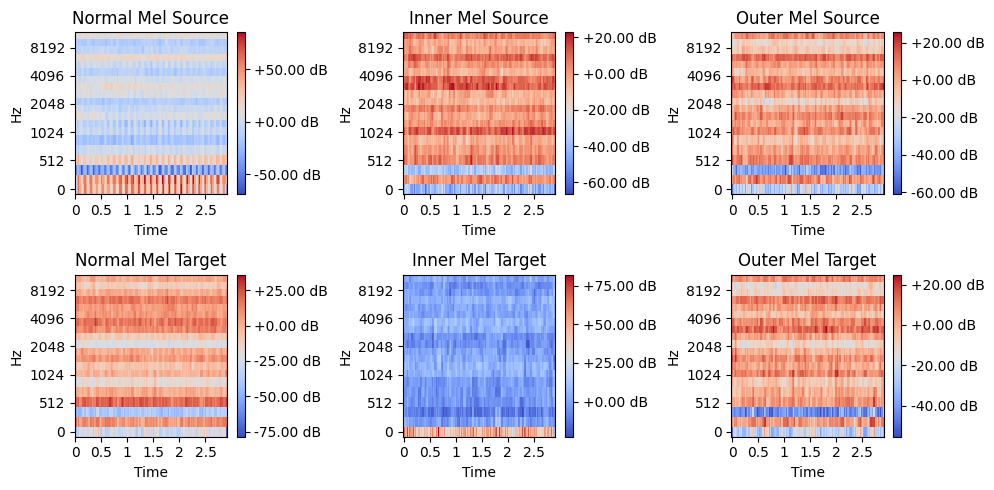

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# Plot 1 - Normal MFCC
axs[0, 0].set_title('Normal Mel Source')
img1 = librosa.display.specshow(source[s_n], x_axis='time',  y_axis='mel', ax=axs[0, 0])
fig.colorbar(img1, ax=axs[0, 0], format='%+2.2f dB')

# Plot 2 - Inner MFCC
axs[0, 1].set_title('Inner Mel Source')
img2 = librosa.display.specshow(source[s_i], x_axis='time',  y_axis='mel', ax=axs[0, 1])
fig.colorbar(img2, ax=axs[0, 1], format='%+2.2f dB')

# Plot 3 - Outer MFCC
axs[0, 2].set_title('Outer Mel Source')
img3 = librosa.display.specshow(source[s_o], x_axis='time', y_axis='mel', ax=axs[0, 2])
fig.colorbar(img3, ax=axs[0, 2], format='%+2.2f dB')

# Plot 4 - Normal MFCC
axs[1, 0].set_title('Normal Mel Target')
img4 = librosa.display.specshow(target[t_n], x_axis='time', y_axis='mel', ax=axs[1, 0])
fig.colorbar(img4, ax=axs[1, 0], format='%+2.2f dB')

# Plot 5 - Inner MFCC
axs[1, 1].set_title('Inner Mel Target')
img5 = librosa.display.specshow(target[t_i], x_axis='time',  y_axis='mel', ax=axs[1, 1])
fig.colorbar(img5, ax=axs[1, 1], format='%+2.2f dB')

# Plot 6 - Outer MFCC
axs[1, 2].set_title('Outer Mel Target')
img6 = librosa.display.specshow(target[t_o], x_axis='time',  y_axis='mel', ax=axs[1, 2])
fig.colorbar(img6, ax=axs[1, 2], format='%+2.2f dB')

plt.tight_layout()
plt.show()


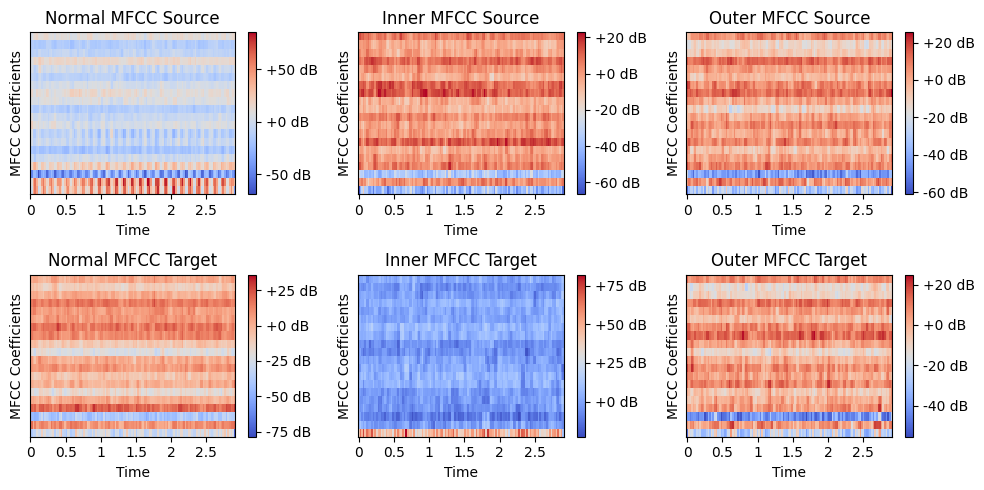

In [29]:

fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# Plot 1 - Normal MFCC
axs[0, 0].set_title('Normal MFCC Source')
img1 = librosa.display.specshow(source[s_n], x_axis='time', cmap='coolwarm', ax=axs[0, 0])
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('MFCC Coefficients')
fig.colorbar(img1, ax=axs[0, 0], format='%+2.0f dB')

# Plot 2 - Inner MFCC
axs[0, 1].set_title('Inner MFCC Source')
img2 = librosa.display.specshow(source[s_i], x_axis='time', cmap='coolwarm', ax=axs[0, 1])
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('MFCC Coefficients')
fig.colorbar(img2, ax=axs[0, 1], format='%+2.0f dB')

# Plot 3 - Outer MFCC
axs[0, 2].set_title('Outer MFCC Source')
img3 = librosa.display.specshow(source[s_o], x_axis='time', cmap='coolwarm', ax=axs[0, 2])
axs[0, 2].set_xlabel('Time')
axs[0, 2].set_ylabel('MFCC Coefficients')
fig.colorbar(img3, ax=axs[0, 2], format='%+2.0f dB')

# Plot 4 - Normal MFCC
axs[1, 0].set_title('Normal MFCC Target')
img4 = librosa.display.specshow(target[t_n], x_axis='time', cmap='coolwarm', ax=axs[1, 0])
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('MFCC Coefficients')
fig.colorbar(img4, ax=axs[1, 0], format='%+2.0f dB')

# Plot 5 - Inner MFCC
axs[1, 1].set_title('Inner MFCC Target')
img5 = librosa.display.specshow(target[t_i], x_axis='time', cmap='coolwarm', ax=axs[1, 1])
axs[1, 1].set_xlabel('Time')
axs[1, 1].set_ylabel('MFCC Coefficients')
fig.colorbar(img5, ax=axs[1, 1], format='%+2.0f dB')

# Plot 6 - Outer MFCC
axs[1, 2].set_title('Outer MFCC Target')
img6 = librosa.display.specshow(target[t_o], x_axis='time', cmap='coolwarm', ax=axs[1, 2])
axs[1, 2].set_xlabel('Time')
axs[1, 2].set_ylabel('MFCC Coefficients')
fig.colorbar(img6, ax=axs[1, 2], format='%+2.0f dB')

plt.tight_layout()
plt.show()


In [30]:
import torch
from torch.utils.data import TensorDataset

In [31]:
import torch
from torch.utils.data import Dataset

class MyCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]


        # Apply transformations if specified
        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [32]:
def load_training(images, labels, batch_size):
    transform = transforms.Compose([
        #transforms.Resize(224,224),
        #transforms.RandomHorizontalFlip(),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Create a custom dataset using the provided images and labels
    dataset = MyCustomDataset(images, labels, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

In [33]:
num_class = 3
max_epoch = 30
batch_size = 128
learning_rate = 0.02
t_correct = 0
updata = 2

In [34]:
src_data_loader = load_training(source, y_source, batch_size)
tgt_data_loader = load_training(target_train, y_train, batch_size)
test_data_loader = load_training(target_test, y_test, batch_size)

In [35]:
transform = transforms.Compose([
        transforms.ToTensor(),
    ])

test_dataset = MyCustomDataset(target_test, y_test, transform=transform)

#### Make classifier

In [36]:
class VGG16Classifier(nn.Module):
    def __init__(self, init_weights=True, num_class=3, input_size= 74240):
        self.num_class = num_class
        super(VGG16Classifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(input_size,64),
            nn.BatchNorm1d(64),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(64, num_class),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        loss = 0
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


#### Make custom feature generator

In [37]:
class MyModel(nn.Module):
    def __init__(self, num_class):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(24, 64, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=0),
            nn.ReLU(),

        )
        self.classifier = VGG16Classifier(num_class=num_class)

    def forward(self, x):
        x = self.features(x)


        return x

In [38]:
import torch

# Define the input image size
batch_size = 32
num_channels = 1
height = 20
width = 126

# Create a random input tensor with the specified size
input_tensor = torch.randn(batch_size, num_channels, height, width)

# Pass the input tensor through the convolutions in your MyModel
features = MyModel(num_class=num_class).features
output_tensor = features(input_tensor)

# Get the size of the output tensor
output_size = output_tensor.size()

# Calculate the input size for the linear layer
input_size = output_size[1] * output_size[2] * output_size[3]

print("Input size for the linear layer:", input_size)

Input size for the linear layer: 74240


In [39]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(24, 64, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=0),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.features(x)
        return x


In [40]:
# Initialize Generator and optimizers
generator = Generator()
classifier = VGG16Classifier(num_class=num_class)
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate)
opt_classifier = optim.Adam(classifier.parameters(), lr=learning_rate)

In [41]:
def pretrain_generator_and_classifier(generator, Classifier, datasets_source, opt_generator, opt_classifier, max_epoch):
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection
    criterion = nn.CrossEntropyLoss()
    generator.train()
    Classifier.train()

    for ep in range(max_epoch):
        correct_count = 0
        total_samples = 0

        for images_src, label in datasets_source:
            img_src = images_src.float()
            label_src = label.squeeze_()

            opt_generator.zero_grad()
            opt_classifier.zero_grad()

            feat_src = generator(img_src)
            pred_src_c = Classifier(feat_src)

            loss_src_c = criterion(pred_src_c, label_src)

            loss_src = loss_src_c
            loss_src.backward()

            opt_generator.step()
            opt_classifier.step()

            # Calculate accuracy
            _, predicted = torch.max(pred_src_c.data, 1)
            correct_count += (predicted == label_src).sum().item()
            total_samples += label_src.size(0)

        accuracy = correct_count / total_samples
        print('Pretrain Epoch:{} Generator Loss: {:.6f} Accuracy: {:.2%}'.format(ep + 1, loss_src.item(), accuracy))


In [42]:
# Call the pretrain_generator_and_classifier function
pretrain_generator_and_classifier(generator, classifier, src_data_loader, opt_generator, opt_classifier, max_epoch)

Pretrain Epoch:1 Generator Loss: 0.771775 Accuracy: 45.78%
Pretrain Epoch:2 Generator Loss: 0.677918 Accuracy: 68.75%
Pretrain Epoch:3 Generator Loss: 0.395199 Accuracy: 78.91%
Pretrain Epoch:4 Generator Loss: 0.252769 Accuracy: 86.41%
Pretrain Epoch:5 Generator Loss: 0.252672 Accuracy: 89.38%
Pretrain Epoch:6 Generator Loss: 0.186352 Accuracy: 92.50%
Pretrain Epoch:7 Generator Loss: 0.176561 Accuracy: 93.59%
Pretrain Epoch:8 Generator Loss: 0.109338 Accuracy: 94.84%
Pretrain Epoch:9 Generator Loss: 0.130639 Accuracy: 92.66%
Pretrain Epoch:10 Generator Loss: 0.139022 Accuracy: 93.59%
Pretrain Epoch:11 Generator Loss: 0.151541 Accuracy: 96.88%
Pretrain Epoch:12 Generator Loss: 0.104779 Accuracy: 95.00%
Pretrain Epoch:13 Generator Loss: 0.079853 Accuracy: 95.62%
Pretrain Epoch:14 Generator Loss: 0.078371 Accuracy: 95.47%
Pretrain Epoch:15 Generator Loss: 0.092445 Accuracy: 96.88%
Pretrain Epoch:16 Generator Loss: 0.080859 Accuracy: 96.72%
Pretrain Epoch:17 Generator Loss: 0.040200 Accura

In [43]:
Generator = generator.features
Classifier = VGG16Classifier(num_class=num_class)
Classifier1 = VGG16Classifier(num_class=num_class)
Classifier2 = VGG16Classifier(num_class=num_class)

In [44]:
# Load trained weights into the Classifier instances
Classifier.load_state_dict(classifier.state_dict())
Classifier1.load_state_dict(classifier.state_dict())
Classifier2.load_state_dict(classifier.state_dict())

<All keys matched successfully>

In [45]:
opt_generator = optim.Adam(Generator.parameters(), lr=learning_rate, weight_decay=0.0005)
opt_classifier = optim.Adam(Classifier.parameters(), lr=learning_rate, weight_decay=0.0005)
opt_classifier1 = optim.Adam(Classifier1.parameters(), lr=learning_rate, weight_decay=0.0005)
opt_classifier2 = optim.Adam(Classifier2.parameters(), lr=learning_rate, weight_decay=0.0005)


In [46]:
def reset_grad():
    opt_generator.zero_grad()
    opt_classifier.zero_grad()
    opt_classifier1.zero_grad()
    opt_classifier2.zero_grad()

In [47]:
def make_variable(tensor):
    return tensor

### Training

In [48]:
def test():
    Generator.eval()
    Classifier.eval()
    correct = 0
    size = 0
    t_correct = 0

    data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    for data, target in data_loader:
        img = make_variable(data.float())
        label = make_variable(target)

        feat = Generator(img)
        pred = Classifier(feat)

        _, pred = torch.max(pred.data, 1)
        correct += pred.eq(label.data).cpu().sum().item()
        size += label.size(0)

        if correct > t_correct:
            t_correct = correct

    print('Source: {} to Target: {}  Accuracy: {}/{} ({:.2f}%) Max Accuracy: {}/{} ({:.2f}%)'.format(
        "CaseA", "CaseB", correct, size, 100. * correct / size, t_correct, size, 100. * t_correct / size))


In [49]:
def train_model(Generator, Classifier, Classifier1, Classifier2, datasets_source, dataset_target, max_epoch, opt_generator, opt_classifier, opt_classifier1, opt_classifier2, updata):
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection
    criterion = nn.CrossEntropyLoss()
    Generator.train()
    Classifier.train()
    Classifier1.train()
    Classifier2.train()
    #torch.cuda.manual_seed(1)

    for ep in range(max_epoch):
        data_zip = enumerate(zip(datasets_source, dataset_target))
        for step, ((images_src, label), (images_tgt, _)) in data_zip:
            img_src = make_variable(images_src.float())
            label_src = make_variable(label.squeeze_())
            img_tgt = make_variable(images_src.float())

            reset_grad()
            feat_src = Generator(img_src)
            pred_src_c = Classifier(feat_src)
            pred_src_c1 = Classifier1(feat_src)
            pred_src_c2 = Classifier2(feat_src)

            loss_src_c = criterion(pred_src_c, label_src)
            loss_src_c1 = criterion(pred_src_c1, label_src)
            loss_src_c2 = criterion(pred_src_c2, label_src)
            loss_src = loss_src_c + loss_src_c1 + loss_src_c2

            loss_src.backward()
            opt_generator.step()
            opt_classifier.step()
            opt_classifier1.step()
            opt_classifier2.step()

            reset_grad()
            feat_src = Generator(img_src)
            pred_src_c1 = Classifier1(feat_src)
            pred_src_c2 = Classifier2(feat_src)
            loss_src_c1 = criterion(pred_src_c1, label_src)
            loss_src_c2 = criterion(pred_src_c2, label_src)
            loss_src = loss_src_c1 + loss_src_c2

            feat_tgt = Generator(img_tgt)
            pred_tgt_c1 = Classifier1(feat_tgt)
            pred_tgt_c2 = Classifier2(feat_tgt)
            p1 = F.softmax(pred_tgt_c1, dim=1)
            p2 = F.softmax(pred_tgt_c2, dim=1)
            loss_adv = torch.mean(torch.abs(p1 - p2))
            loss = loss_src - loss_adv

            loss.backward()
            opt_classifier1.step()
            opt_classifier2.step()

            reset_grad()

            for i in range(updata):
                feat_tgt = Generator(img_tgt)
                pred_tgt_c1 = Classifier1(feat_tgt)
                pred_tgt_c2 = Classifier2(feat_tgt)
                p1 = F.softmax(pred_tgt_c1, dim=1)
                p2 = F.softmax(pred_tgt_c2, dim=1)
                loss_adv = torch.mean(torch.abs(p1 - p2))

                loss_adv.backward()
                opt_generator.step()
                reset_grad()

        print('Train Epoch:{} Adversarial Loss: {:.6f}'.format(ep + 1, loss_adv.item()))
        print('Train Epoch:{} Classification Loss: {:.6f}'.format(ep + 1, loss.item()))
        test()



In [50]:
num_class = 3
max_epoch = 30
batch_size = 128
learning_rate = 0.02
t_correct = 0
updata = 2

In [51]:
# Call the function // lr = 0.02  // normalised // 128 -batch  30 epoch  // caaseA to caseB 2 updata smaller classifier 64
train_model(Generator, Classifier, Classifier1, Classifier2, src_data_loader, tgt_data_loader, max_epoch, opt_generator, opt_classifier, opt_classifier1, opt_classifier2, updata)

Train Epoch:1 Adversarial Loss: 0.055163
Train Epoch:1 Classification Loss: 0.090422
Source: CaseA to Target: CaseB  Accuracy: 127/200 (63.50%) Max Accuracy: 127/200 (63.50%)
Train Epoch:2 Adversarial Loss: 0.049482
Train Epoch:2 Classification Loss: 0.128371
Source: CaseA to Target: CaseB  Accuracy: 71/200 (35.50%) Max Accuracy: 71/200 (35.50%)
Train Epoch:3 Adversarial Loss: 0.080975
Train Epoch:3 Classification Loss: 0.318782
Source: CaseA to Target: CaseB  Accuracy: 123/200 (61.50%) Max Accuracy: 123/200 (61.50%)
Train Epoch:4 Adversarial Loss: 0.046673
Train Epoch:4 Classification Loss: 0.251422
Source: CaseA to Target: CaseB  Accuracy: 169/200 (84.50%) Max Accuracy: 169/200 (84.50%)
Train Epoch:5 Adversarial Loss: 0.034761
Train Epoch:5 Classification Loss: 0.113849
Source: CaseA to Target: CaseB  Accuracy: 172/200 (86.00%) Max Accuracy: 172/200 (86.00%)
Train Epoch:6 Adversarial Loss: 0.033157
Train Epoch:6 Classification Loss: 0.086734
Source: CaseA to Target: CaseB  Accuracy: 

## Wessesterian Loss


In [52]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [53]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)

    return penalty

In [54]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp

    return crit_loss

In [55]:
c_lambda = 10

In [56]:
def train_model(Generator, Classifier, Classifier1, Classifier2, datasets_source, dataset_target, max_epoch, opt_generator, opt_classifier, opt_classifier1, opt_classifier2, updata):
    torch.autograd.set_detect_anomaly(True)  # Enable anomaly detection
    criterion = nn.CrossEntropyLoss()
    Generator.train()
    Classifier.train()
    Classifier1.train()
    Classifier2.train()
    #torch.cuda.manual_seed(1)

    for ep in range(max_epoch):
        data_zip = enumerate(zip(datasets_source, dataset_target))
        for step, ((images_src, label), (images_tgt, _)) in data_zip:
            img_src = make_variable(images_src.float())
            label_src = make_variable(label.squeeze_())
            img_tgt = make_variable(images_src.float())
            reset_grad()
            feat_src = Generator(img_src)
            pred_src_c = Classifier(feat_src)
            pred_src_c1 = Classifier1(feat_src)
            pred_src_c2 = Classifier2(feat_src)

            loss_src_c = criterion(pred_src_c, label_src)
            loss_src_c1 = criterion(pred_src_c1, label_src)
            loss_src_c2 = criterion(pred_src_c2, label_src)
            loss_src = loss_src_c + loss_src_c1 + loss_src_c2

            loss_src.backward()
            opt_generator.step()
            opt_classifier.step()
            opt_classifier1.step()
            opt_classifier2.step()

            reset_grad()
            feat_src = Generator(img_src)
            pred_src_c1 = Classifier1(feat_src)
            pred_src_c2 = Classifier2(feat_src)
            loss_src_c1 = criterion(pred_src_c1, label_src)
            loss_src_c2 = criterion(pred_src_c2, label_src)
            loss_src = loss_src_c1 + loss_src_c2

            feat_tgt = Generator(img_tgt)
            pred_tgt_c1 = Classifier1(feat_tgt)
            pred_tgt_c2 = Classifier2(feat_tgt)
            p1 = F.softmax(pred_tgt_c1, dim=1)
            p2 = F.softmax(pred_tgt_c2, dim=1)
            loss_adv = torch.mean(torch.abs(p1 - p2))

            epsilon = torch.rand(feat_src.size(), requires_grad=True)
            gradient1 = get_gradient(Classifier1, feat_src, feat_tgt, epsilon)
            gp1 = gradient_penalty(gradient1)
            crit_loss1 = get_crit_loss(pred_tgt_c1, pred_src_c1, gp1, c_lambda)

            gradient2 = get_gradient(Classifier2, feat_src, feat_tgt, epsilon)
            gp2 = gradient_penalty(gradient2)
            crit_loss2 = get_crit_loss(pred_tgt_c2, pred_src_c2, gp2, c_lambda)


            loss = loss_src - loss_adv + crit_loss1 + crit_loss2
            loss.backward()
            opt_classifier1.step()
            opt_classifier2.step()

            reset_grad()

            for i in range(updata):
                feat_tgt = Generator(img_tgt)
                pred_tgt_c1 = Classifier1(feat_tgt)
                pred_tgt_c2 = Classifier2(feat_tgt)
                p1 = F.softmax(pred_tgt_c1, dim=1)
                p2 = F.softmax(pred_tgt_c2, dim=1)
                loss_adv = torch.mean(torch.abs(p1 - p2))

                loss_adv.backward()
                opt_generator.step()
                reset_grad()

        print('Train Epoch:{} Adversarial Loss: {:.6f}'.format(ep + 1, loss_adv.item()))
        print('Train Epoch:{} Classification Loss: {:.6f}'.format(ep + 1, loss.item()))
        test()



In [57]:
num_class = 3
max_epoch = 30
batch_size = 128
learning_rate = 0.02
t_correct = 0
updata = 1

In [ ]:
# Call the function // lr = 0.02  // 256 30 epoch without alignment 2 updata // From A to B 2 updata smaller classifier
train_model(Generator, Classifier, Classifier1, Classifier2, src_data_loader, tgt_data_loader, max_epoch, opt_generator, opt_classifier, opt_classifier1, opt_classifier2, updata)

Train Epoch:1 Adversarial Loss: 0.051341
Train Epoch:1 Classification Loss: 20.364752
Source: CaseA to Target: CaseB  Accuracy: 175/200 (87.50%) Max Accuracy: 175/200 (87.50%)
Train Epoch:2 Adversarial Loss: 0.030626
Train Epoch:2 Classification Loss: 19.982521
Source: CaseA to Target: CaseB  Accuracy: 177/200 (88.50%) Max Accuracy: 177/200 (88.50%)
Train Epoch:3 Adversarial Loss: 0.047933
Train Epoch:3 Classification Loss: 20.354961
Source: CaseA to Target: CaseB  Accuracy: 182/200 (91.00%) Max Accuracy: 182/200 (91.00%)
Train Epoch:4 Adversarial Loss: 0.032137
Train Epoch:4 Classification Loss: 20.034653
Source: CaseA to Target: CaseB  Accuracy: 185/200 (92.50%) Max Accuracy: 185/200 (92.50%)
Train Epoch:5 Adversarial Loss: 0.050832
Train Epoch:5 Classification Loss: 20.287722
Source: CaseA to Target: CaseB  Accuracy: 184/200 (92.00%) Max Accuracy: 184/200 (92.00%)
Train Epoch:6 Adversarial Loss: 0.045384
Train Epoch:6 Classification Loss: 20.248878
Source: CaseA to Target: CaseB  Ac

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
